### Localization with SVM classifier 

Uses multiscale sliding window with SVM to detect DICE coefficient, accuracy, precision and recall on localization dataset.  

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import time
import imutils
import csv
from scipy.spatial import distance
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [19]:
# Load SVM model
svmClassifier = joblib.load('finalized_model_updated.pk1')

In [20]:
# Extract ground truth localization values from gt_train.csv 
ground_truth_id = []
ground_truth_class = []
ground_truth_coordinates = []

with open('MIO-TCD-Localization/gt_train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        ground_truth_id.append(row[0])
        ground_truth_class.append(row[1])
        coordinates = list(map(int,[row[2],row[3],row[4],row[5]]))
        ground_truth_coordinates.append(coordinates)
        
        if line_count == 0:
            line_count += 1
        else:
            line_count += 1
            
ground_truth_id = np.array(ground_truth_id)
ground_truth_class = np.array(ground_truth_class)
ground_truth_coordinates = np.array(ground_truth_coordinates)

In [21]:
def getHogFeatures(images):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins
    
    hog = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                          images[0].shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
    
    n_cells = (images[0].shape[0] // cell_size[0], images[0].shape[1] // cell_size[1])
    
    listOfHogFeatures = []
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.
        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        # turn gradient 32,32,8 3D array to 1D for training 
        reshaped_gradients = gradients.ravel()
        listOfHogFeatures.append(reshaped_gradients)
        
    return listOfHogFeatures

In [22]:
def calculate_dice_coefficient(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return dice coefficient based on intersection of union
    dice_coefficient = (2 * iou)/(iou + 1)
    
    return dice_coefficient

In [23]:
# extract images from localization MIO-TCD-Localization dataset
def extract_localization_images(path, extracted_images, extracted_value, image_ids):
    extracted_count = 0

    for file in os.listdir(path):
        if (extracted_count < extracted_value):
            img = cv2.cvtColor(cv2.imread(os.path.join(path + "/" + file)), cv2.COLOR_BGR2GRAY)
            extracted_images.append(img)
            extracted_count = extracted_count + 1 
            image_ids.append(""+file[:-4])
        else:
            break
                            
    return extracted_images


In [24]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [26]:
def draw_gt_values(img, class_coordinates):
    
    for coordinates in class_coordinates:
        xy = (int(coordinates[0]), int(coordinates[1]))
        w = int(coordinates[2])
        h = int(coordinates[3])
        cv2.rectangle(img, xy, (w,h), (0,255,0), 2)

In [27]:
def get_ground_truth_values(image_id):
    classes = ground_truth_class[ground_truth_id == image_id]
    class_coordinates = ground_truth_coordinates[ground_truth_id == image_id]
    return classes, class_coordinates

In [46]:
def multi_scale_sliding_window(localization_image, img, window_width, window_height, step_size, window_scales):
    patches = []
    patches_coordinates = []
    patches_classes = []
    
    # loop over different window scales
    for scale in window_scales:
        window_size = (int(window_width * scale), int(window_height * scale))
        color = tuple(np.random.randint(0, 255, 3).tolist())
        for (x, y, window) in sliding_window(localization_image, stepSize=step_size, windowSize=window_size):
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] < int(window_width*scale) or window.shape[1] < int(window_height*scale):
                continue
            
            resized_window = cv2.resize(window,(window_width,window_height))
            window_hog_features = getHogFeatures([resized_window])
            prediction = svmClassifier.predict(window_hog_features)
            
            # if prediction wasn't a background then keep the window's bounding box 
            if (prediction != 1):
                cv2.rectangle(img, (x, y), (x + int(window_width*scale), y + int(window_height*scale)), color, 2)
                patches.append(window)
                patches_coordinates.append([x,y,x+int(window_width*scale),y+int(window_width*scale)])
                patches_classes.append(prediction)
        
    return patches, patches_coordinates, patches_classes

In [47]:
# calculate best MEAN coefficient from best bounding boxes.
def calculate_localization_results(localization_image, gt_classes, gt_class_coordinates, patches, patches_coordinates, patches_classes):
    dice_coefficient_values = []
    prediction_results = []
    for gt_class, gt_coordinates in zip(gt_classes, gt_class_coordinates):
        closest_coordinates = []
        for patch, p_coordinates in zip(patches, patches_coordinates):
            distance_from_gt = distance.euclidean(p_coordinates, gt_coordinates)
            closest_coordinates.append(distance_from_gt)

        closest_coordinates = np.array(closest_coordinates)
        min_index = np.argmin(closest_coordinates)
        min_coordinates = patches_coordinates[min_index]

        dice_coefficient = calculate_dice_coefficient(min_coordinates, gt_coordinates)
        dice_coefficient_values.append(dice_coefficient)

        prediction_results.append(patches_classes[min_index])
        
        # Draw best bounding boxes and and ground truth boxes.
        cv2.rectangle(localization_image,(min_coordinates[0],min_coordinates[1]), (min_coordinates[2],min_coordinates[3]), (0,0,255), 2) 
    
    mean_dice_coefficient = np.mean(dice_coefficient_values)
    return mean_dice_coefficient, prediction_results

In [48]:
# SVM model convert numerical label into proper string label. 

def convert_int_to_class(prediction):
    if (prediction == 1):
        return "background"
    elif (prediction == 0):
        return "articulated_truck"
    elif (prediction == 2):
        return "bicycle"
    elif (prediction == 3):
        return "bus"
    elif (prediction == 4):
        return "car"
    elif (prediction == 5):
        return "motorcycle"
    elif (prediction == 6):
        return "non-motorized_vehicle"
    elif (prediction == 7):
        return "pedestrian"
    elif (prediction == 8):
        return "pickup_truck"
    elif (prediction == 9):
        return "single_unit_truck"
    elif (prediction == 10):
        return "work_van"

###  Localization with HoG and SVM

In [49]:
# extract 500 localization images.

training_set_path= r"./MIO-TCD-Localization/train"
train_images = []
train_value = 500
image_ids = []

extract_localization_images(training_set_path, train_images, train_value,image_ids)
print(len(train_images))
print(len(image_ids))

500
500


#### Cross validation

In [51]:
kf_splitter = KFold(n_splits=10)

valid_label_prediction_accuracy = []
valid_label_prediction_precision = []
valid_label_prediction_recall = []
valid_mean_dice_coefficient = []

train_images = np.array(train_images)
image_ids = np.array(image_ids)
validation_index = 0

for train_index, valid_index in kf_splitter.split(train_images):
    print("LOCALIZING VALIDATION SET : ", validation_index)
    
    # Get our validation data in this fold
    valid_set = train_images[valid_index]
    valid_image_ids = image_ids[valid_index]
    
    # set localization parameters 
    dice_coefficient_images = []
    all_class_predictions = []
    all_ground_truth_classes = []

    window_width = 80
    window_height = 80
    step_size = 32 
    window_scales = [0.75,1,1.25,1.5]
    
    # Start localization for validation set
    for localization_image, image_id in zip(valid_set,valid_image_ids):
        img = cv2.imread(r"./MIO-TCD-Localization/train/"+ str(image_id) + ".jpg")
        
        patches, patches_coordinates, patches_classes = multi_scale_sliding_window(localization_image, img, window_width, window_height, step_size, window_scales)

        gt_classes, gt_class_coordinates = get_ground_truth_values(image_id)

        patches_classes = np.array(patches_classes)
        
        draw_gt_values(img, gt_class_coordinates)

        localization_image_dice, class_predictions = calculate_localization_results(img, gt_classes, gt_class_coordinates, patches, patches_coordinates, patches_classes)
        
        dice_coefficient_images.append(localization_image_dice)

        for prediction in class_predictions:
            all_class_predictions.append(convert_int_to_class(prediction))
        for gt_class in gt_classes:
            all_ground_truth_classes.append(gt_class)
        
        # save image with bounding boxes for observation purposes
        cv2.imwrite("./svm_localization/" + str(image_id)+"_svm" + ".jpg",img)
         
    valid_mean_dice_coefficient.append(dice_coefficient_images)    
    
    accuracy = accuracy_score(all_class_predictions, all_ground_truth_classes)
    #print("LOCALIZATION + CLASSIFICATION ACCURACY : ", accuracy)
    valid_label_prediction_accuracy.append(accuracy)
    
    precision = precision_score(all_class_predictions, all_ground_truth_classes, average = 'micro')
    #print("LOCALIZATION + CLASSIFICATION PRECISION : ", precision)
    valid_label_prediction_precision.append(precision)
    
    recall = recall_score(all_class_predictions, all_ground_truth_classes, average='micro')
    #print("LOCALIZATION + CLASSIFICATION RECALL : ", recall)
    valid_label_prediction_recall.append(recall)
    
    validation_index = validation_index + 1

    

LOCALIZING VALIDATION SET :  0
LOCALIZING VALIDATION SET :  1
LOCALIZING VALIDATION SET :  2
LOCALIZING VALIDATION SET :  3
LOCALIZING VALIDATION SET :  4
LOCALIZING VALIDATION SET :  5
LOCALIZING VALIDATION SET :  6
LOCALIZING VALIDATION SET :  7
LOCALIZING VALIDATION SET :  8
LOCALIZING VALIDATION SET :  9


AVERAGE DICE COEFFICIENT OF VALID SET :  51.627699804335904 %


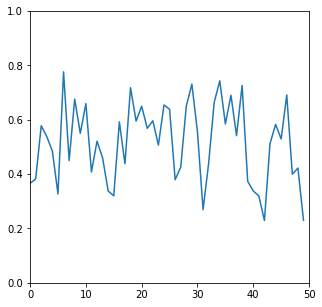

AVERAGE DICE COEFFICIENT OF VALID SET :  51.18258601490345 %


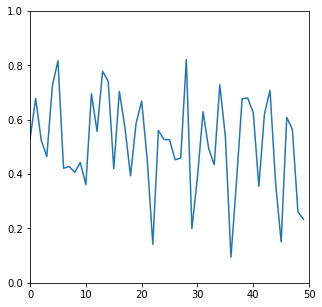

AVERAGE DICE COEFFICIENT OF VALID SET :  52.50128603953614 %


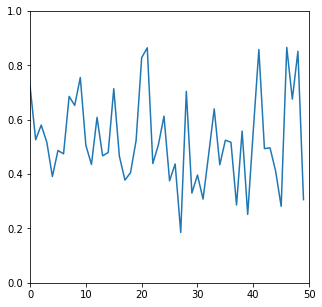

AVERAGE DICE COEFFICIENT OF VALID SET :  53.25664995204953 %


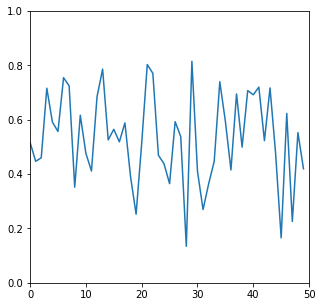

AVERAGE DICE COEFFICIENT OF VALID SET :  52.040147507172996 %


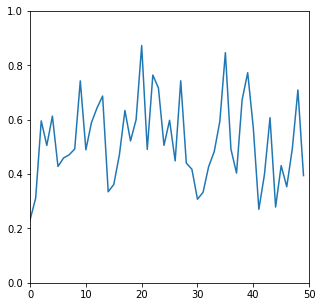

AVERAGE DICE COEFFICIENT OF VALID SET :  50.73188980617552 %


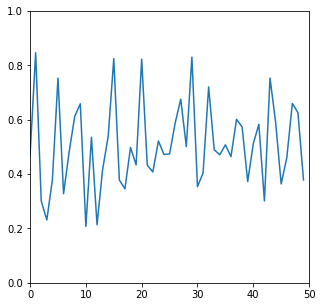

AVERAGE DICE COEFFICIENT OF VALID SET :  48.68943355756977 %


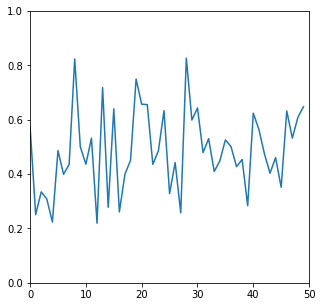

AVERAGE DICE COEFFICIENT OF VALID SET :  47.34292540209466 %


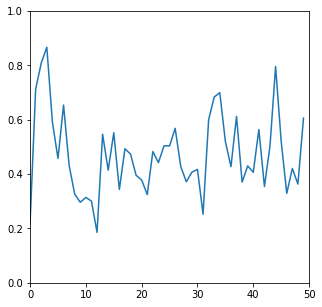

AVERAGE DICE COEFFICIENT OF VALID SET :  51.35915790026891 %


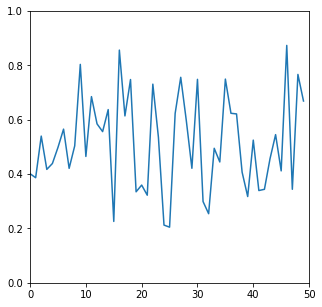

AVERAGE DICE COEFFICIENT OF VALID SET :  53.6808484746885 %


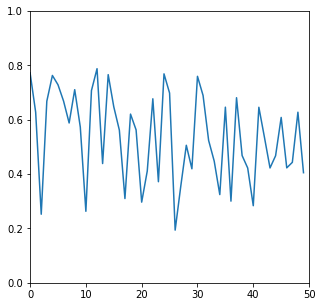

MEAN DICE COEFFICIENT OF ALL VALID SETS :  51.24126244587954 %


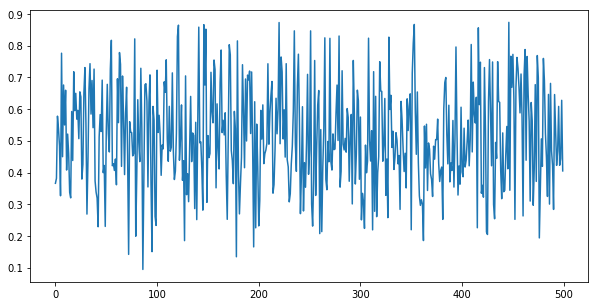

In [52]:
# distribution of validation set DICE Coefficient 

all_dice_coefficient = []


image_index = []
for i in range(len(valid_set)):
    image_index.append(i)

# Plot each validation set DICE coefficient for each image
for dice_coefficient in valid_mean_dice_coefficient:    
    all_dice_coefficient = all_dice_coefficient + dice_coefficient
    print("AVERAGE DICE COEFFICIENT OF VALID SET : ", str(np.mean(dice_coefficient)* 100) + " %")
    plt.figure(figsize=(5,5))
    plt.plot(image_index,dice_coefficient)
    plt.axis([0, len(image_index), 0, 1])
    plt.show()
    
# Plot all validation sets coefficient  

image_index = []
for i in range(len(valid_set * 10)):
    image_index.append(i)
    
plt.figure(figsize=(10,5))
print("MEAN DICE COEFFICIENT OF ALL VALID SETS : ", str(np.mean(valid_mean_dice_coefficient)* 100)+ " %")
plt.plot(all_dice_coefficient)
plt.show()

    


In [54]:
print("AVERAGE SVM ACCURACY SCORE : ", str(np.mean(valid_label_prediction_accuracy) * 100) + " %")
print("STANDARD SVM DEVIATION : ", str(np.std(valid_label_prediction_accuracy) * 100) + " %")
print("AVERAGE SVM RECALL SCORE : ", str(np.mean(valid_label_prediction_recall) * 100) + " %")
print("AVERAGE SVM PRECISION SCORE : ", str(np.mean(valid_label_prediction_precision) * 100) + " %")

AVERAGE SVM ACCURACY SCORE :  12.386508678843523 %
STANDARD SVM DEVIATION :  2.6846746995675974 %
AVERAGE SVM RECALL SCORE :  12.386508678843523 %
AVERAGE SVM PRECISION SCORE :  12.386508678843523 %
